# ***Loading the data***

In [1]:
!pip install kagglehub --quiet

In [2]:
!pip install librosa soundfile --quiet

In [3]:
# Libs for loading the data
import os
import pandas as pd
import numpy as np
import kagglehub
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import soundfile as sf
from collections import Counter
from random import sample

In [ ]:
if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("Please upload your kaggle.json API key file") # This is to download the EMOTIC dataset
    from google.colab import files
    uploaded = files.upload()  # Upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

## Load EMOTIC dataset

In [5]:
dataset_path = kagglehub.dataset_download("magdawjcicka/emotic")
img_dir = f"{dataset_path}/img_arrs"
print("EMOTIC image data path:", img_dir)

EMOTIC image data path: /kaggle/input/emotic/img_arrs


# Load audio files and .txt matching files from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [78]:
# !ls "/content/drive/MyDrive"

In [8]:
!unzip -q "/content/drive/MyDrive/project_data.zip" -d "/content"

In [9]:
audio_dir = "/content/project_data/music"

In [79]:
#!ls /content/project_data

In [ ]:
df_train = pd.read_csv("/content/project_data/cleaned_train_matching.txt", sep=' ', header=None, names=["audio_id", "image_file", "score"])
df_val = pd.read_csv("/content/project_data/cleaned_val_matching.txt", sep=' ', header=None, names=["audio_id", "image_file", "score"])
df_test = pd.read_csv("/content/project_data/cleaned_test_matching.txt", sep=' ', header=None, names=["audio_id", "image_file", "score"])

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

In [12]:
class ImageAudioDataset(Dataset):
    def __init__(self, df, img_dir, audio_dir, sr=44100, max_sec=50):
        """
        sr : int, optional
            Target sampling rate for audio files. All audio will be resampled to this rate. Default is 44100 Hz.
        max_sec : int, optional
            Maximum duration of audio in seconds. Audio will be truncated or zero-padded to exactly `sr * max_sec` samples. Default is 50 seconds.
        """
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.audio_dir = audio_dir
        self.sr = sr
        self.max_len = sr * max_sec  # 50 seconds = 2,205,000 samples
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = os.path.join(self.img_dir, row["image_file"])
        img = np.load(img_path).astype(np.float32) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)  # [H, W, C] → [C, H, W]

        # Load audio
        audio_id = row["audio_id"].split("-")[0]
        audio_path = os.path.join(self.audio_dir, f"{audio_id}.mp3")
        y, _ = librosa.load(audio_path, sr=self.sr)

        # Pad or truncate to exactly 50 seconds
        if len(y) < self.max_len:
            y = np.pad(y, (0, self.max_len - len(y)), mode='constant')
        else:
            y = y[:self.max_len]

        audio_tensor = torch.tensor(y, dtype=torch.float32)

        return {
            "image": img,
            "audio_raw": audio_tensor,
            "score": torch.tensor(row["score"]).float(),
            "audio_id": row["audio_id"]
        }


In [119]:
train_loader = DataLoader(ImageAudioDataset(df_train, img_dir, audio_dir), batch_size=32, shuffle=True)
val_loader = DataLoader(ImageAudioDataset(df_val, img_dir, audio_dir), batch_size=32)
test_loader = DataLoader(ImageAudioDataset(df_test, img_dir, audio_dir), batch_size=32)

# ***Data statistics***

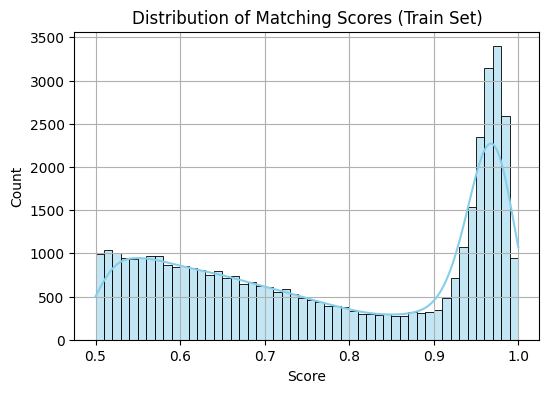

Score stats:
Min: 0.5000008980994213
Max: 0.9998107522735143
Mean: 0.7769


In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(df_train['score'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Matching Scores (Train Set)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

print("Score stats:")
print("Min:", df_train['score'].min())
print("Max:", df_train['score'].max())
print("Mean:", round(df_train['score'].mean(), 4))

In [ ]:
for name, df in zip(['train', 'val', 'test'], [df_train, df_val, df_test]):
    missing = sum(not os.path.exists(os.path.join(img_dir, fname)) for fname in df["image_file"])
    print(f"Missing image files in {name} set: {missing} out of {len(df)}")

Missing image files in train set: 0 out of 41321
Missing image files in val set: 0 out of 3271
Missing image files in test set: 0 out of 10003


In [ ]:
audio_ids = set(os.path.splitext(f)[0] for f in os.listdir(audio_dir) if f.endswith(".mp3"))

# Get numeric part of audio_id from matching files (e.g. "2009-114" → "2009")
def extract_numeric_audio_id(audio_id):
    return audio_id.split("-")[0]

matching_audio_ids = set(
    extract_numeric_audio_id(aid)
    for aid in pd.concat([df_train, df_val, df_test])["audio_id"]
)

# Compare actual vs expected
missing_mp3s = matching_audio_ids - audio_ids
extra_mp3s = audio_ids - matching_audio_ids

print("Total unique numeric audio_ids in matchings:", len(matching_audio_ids))
print("Total uploaded audio files:", len(audio_ids))
print("Missing audio files:", len(missing_mp3s))
print("Extra audio files (not used):", len(extra_mp3s))
if missing_mp3s:
    print("Example missing:", list(missing_mp3s)[:5])

Total unique numeric audio_ids in matchings: 1802
Total uploaded audio files: 1802
Missing audio files: 0
Extra audio files (not used): 0



Number of sampled audio files: 150

Sampled duration stats:
Avg: 51.92 s
Min: 44.86 s
Max: 401.03 s
Median: 45.03 s


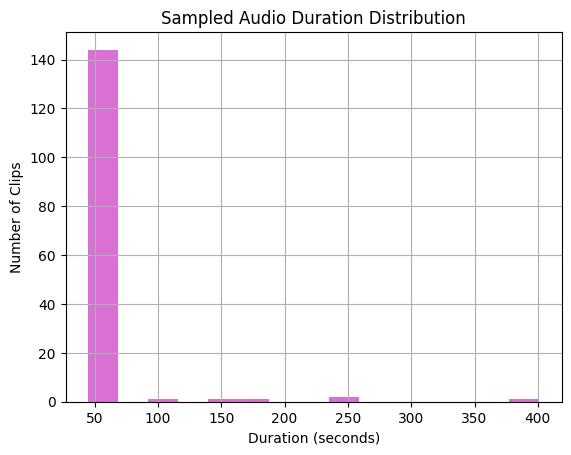

In [ ]:
SAMPLE_FILES_LEN = min(150, len(audio_ids))
sampled_ids = sample(list(audio_ids), SAMPLE_FILES_LEN)

print(f"\nNumber of sampled audio files: {len(sampled_ids)}")

durations = []

for aid in sampled_ids:
    path = os.path.join(audio_dir, f"{aid}.mp3")
    try:
        y, sr = librosa.load(path, sr=None)
        durations.append(len(y) / sr)
    except Exception as e:
        print(f"Failed to load {aid}.mp3:", e)

print("\nSampled duration stats:")
print("Avg:", round(np.mean(durations), 2), "s")
print("Min:", round(np.min(durations), 2), "s")
print("Max:", round(np.max(durations), 2), "s")
print("Median:", round(np.median(durations), 2), "s")

plt.hist(durations, bins=15, color='orchid')
plt.title("Sampled Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Clips")
plt.grid(True)
plt.show()

In [ ]:
sr_list = []
failures = []

for fname in os.listdir(audio_dir):
    if fname.endswith(".mp3"):
        path = os.path.join(audio_dir, fname)
        try:
            info = sf.SoundFile(path)
            sr_list.append(info.samplerate)
        except Exception as e:
            failures.append(fname)

# Count occurrences of each SR
sr_counter = Counter(sr_list)

# Print summary
print("Sampling Rate Distribution (All Files):")
for rate, count in sr_counter.items():
    print(f"{rate} Hz: {count} files")

print(f"\nTotal analyzed: {len(sr_list)}")
print(f"Failed to read: {len(failures)}")
if failures:
    print("Example failed files:", failures[:5])

Sampling Rate Distribution (All Files):
44100 Hz: 1778 files
22050 Hz: 3 files
48000 Hz: 20 files
16000 Hz: 1 files

Total analyzed: 1802
Failed to read: 0


In [ ]:
# Dimensions:
# batch["image"].shape -> [B, 3, 224, 224]
# batch["audio_raw"].shape -> [B, sr * max_sec]
# Optional:
# batch["score"].shape -> [B]
# batch["audio_id"] -> List of IDs

# ***MODEL***

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [134]:
from transformers import ViTModel, ViTImageProcessor, ClapModel, ClapProcessor
import torch
from torchvision import transforms
from torch import nn

# TODO: Maybe compare with a resnet
class ImageEncoder(nn.Module):
    def __init__(self, vit_version):
        super().__init__()
        # Load the model and the class that the inputs go through
        self.model = ViTModel.from_pretrained(vit_version, device_map='auto')
        self.preprocessor = ViTImageProcessor.from_pretrained(vit_version, use_fast=True)

    def encode(self, data):
        inputs = self.preprocessor(images = data, return_tensors="pt", do_normalize=True, do_convert_rgb=True, do_rescale=True, do_resize=True)
        inputs = inputs.to(device)
        outputs = self.model(**inputs)
        return outputs.last_hidden_state

class AudioEncoder(nn.Module):
    def __init__(self, clap_version):
        super().__init__()
        # Load the model and the class that the inputs go through
        self.model = ClapModel.from_pretrained(clap_version, device_map='auto')
        self.preprocessor = ClapProcessor.from_pretrained(clap_version, use_fast=True)

    def encode(self, sampling_rate, waveforms):
        inputs = self.preprocessor(audios=waveforms.numpy(), sampling_rate=sampling_rate, return_tensors='pt')
        inputs = inputs.to(device)
        outputs = self.model.get_audio_features(**inputs)
        return outputs

In [135]:
# Sample usage
data = ImageAudioDataset(df_train, img_dir, audio_dir, sr=48000, max_sec=10)
image_encoder = ImageEncoder("google/vit-base-patch16-224-in21k")
#image_encoder.cuda()#to(torch.device('cuda'))
audio_encoder = AudioEncoder("laion/clap-htsat-unfused")

#print(next(image_encoder.parameters()).is_cuda) # returns a boolean


# Passing through only one example to test it
waveform = data[0]['audio_raw']
audio_embedding = audio_encoder.encode(
   sampling_rate=48000,
   waveforms=waveform, # No need to explicitly torch.unsqueeze this
)
print(audio_embedding.shape)
print(audio_embedding)

image = data[0]['image']#.to(torch.device('cuda'))
#print(image.is_cuda)
#input = image_encoder.preprocess(image).to(torch.device('cuda'))
#print(input['pixel_values'].is_cuda)
image_embedding = image_encoder.encode(
    data=image,
)
print(image_embedding.shape)
print(image_embedding)

# TODO:
# class CLIP(torch.nn.Module)
#   def __init__(self, image_encoder, audio_encoder):
#       self.image_encoder = image_encoder
#       self.audio_encoder = audio_encoder
#       self.image_projection = torch.nn.Sequential([
#           torch.nn.Linear(197 * 768, 197 * 768, bias=False),
#           torch.nn.ReLU(),
#           torch.nn.Linear(197 * 768, 512, bias=False))
#       ])
#       # TODO: Ensure dimensions here are correct and even better, don't hardcode them

#   def forward(self, batch):
#       image_embeddings = self.image_encoder.encode(batch.images) # Pass the images through the ViT
#       audio_embeddings = self.audio_encoder.encode(batch.audio) # Pass the audio through CLAP
#       projected_image_embeddings = self.image_projection(image_embeddings) # this is the MLP/Linear layer
#       # TODO: In the repo code, normalization is applied here - we need to find out if it's necessary
#       # Calculate loss (contrastive)

False
torch.Size([1, 512])
tensor([[-8.5296e-02, -2.6249e-02,  4.0632e-02,  1.0577e-02,  3.4005e-02,
         -2.1650e-02, -7.3908e-04,  2.2290e-02,  8.6597e-02, -5.8448e-02,
         -3.0163e-02, -8.6816e-02, -4.4927e-02,  1.9606e-02, -4.8411e-02,
          4.7513e-02,  1.5340e-02, -9.7588e-02, -4.1862e-03, -1.1842e-02,
          3.1315e-02,  9.7000e-03, -3.0563e-02, -4.1317e-03, -2.9615e-02,
          1.6850e-02,  7.7661e-03,  4.4357e-02,  1.4847e-02, -2.3486e-02,
         -8.6516e-03,  2.9524e-02,  2.3315e-02,  7.0998e-03,  3.1070e-02,
         -3.0500e-02, -1.1185e-02, -2.0414e-02, -8.4843e-02, -2.4246e-02,
          3.3246e-03, -3.4654e-02,  9.4334e-03,  2.5948e-02, -4.5161e-02,
          2.5418e-02,  4.9031e-02, -2.0376e-02,  2.4639e-02, -2.0818e-02,
         -5.7266e-02,  2.1304e-02, -5.8152e-03,  2.4893e-02,  2.5115e-02,
          2.6678e-02, -2.4551e-02, -3.2467e-02, -6.0571e-02,  9.9540e-02,
         -1.0292e-01, -3.8100e-02,  1.0313e-01, -6.0024e-04,  2.0740e-02,
          5

In [136]:
class MLPMapper(torch.nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(in_dim, h_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(h_dim, out_dim)
        )

    def forward(self, x):
        return self.mlp(x)

In [137]:
image_encoder = ImageEncoder("google/vit-base-patch16-224-in21k")
audio_encoder = AudioEncoder("laion/clap-htsat-unfused")

for param in image_encoder.model.parameters():
    param.requires_grad = False
for param in audio_encoder.model.parameters():
    param.requires_grad = False

In [138]:
class PictureToMusicModel(torch.nn.Module):
    def __init__(self, im_dim, au_dim, h_dim, out_dim, im_en, au_en):
        super().__init__()
        self.image_encoder = im_en
        self.audio_encoder = au_en
        self.image_mapper = MLPMapper(im_dim, h_dim, out_dim)
        self.audio_mapper = MLPMapper(au_dim, h_dim, out_dim)
        self.logit_scale = torch.nn.Parameter(torch.tensor(1.0)) # learnable temperature

    def forward(self, image_input, audio_input):
        image_emb = self.image_encoder.encode(data=image_input)
        audio_emb = self.audio_encoder.encode(sampling_rate=48000, waveforms=audio_input)

        image_proj = self.image_mapper(image_emb)
        audio_proj = self.audio_mapper(audio_emb)

        image_proj = torch.nn.functional.normalize(image_proj, dim=-1)
        audio_proj = torch.nn.functional.normalize(audio_proj, dim=-1)

        # clamping (restricting) the temperature
        logit_scale = self.logit_scale.exp()
        logit_scale = torch.clamp(logit_scale, 0, 100)

        return image_proj, audio_proj, logit_scale

### Training Loop

In [155]:
im_dim = 768       # ViT output dim 197x768
h_dim = im_dim * 2
au_dim = 512       # CLAP output dim
out_dim = 512      # Shared space

model = PictureToMusicModel(im_dim, au_dim, h_dim, out_dim, image_encoder, audio_encoder)
model = model.to(device)

In [151]:
from torch.nn.functional import cross_entropy

def contrastive_loss(image_embeds, audio_embeds, logit_scale): # learnable temperature
    logits_per_image = logit_scale * image_embeds @ audio_embeds.T
    logits_per_audio = logits_per_image.T

    labels = torch.arange(image_embeds.size(0)).to(image_embeds.device)

    loss_i2a = cross_entropy(logits_per_image, labels)
    loss_a2i = cross_entropy(logits_per_audio, labels)

    return (loss_i2a + loss_a2i) / 2

optimizer = torch.optim.AdamW([
    {'params': model.image_mapper.parameters(), 'lr': 1e-4},
    {'params': model.audio_mapper.parameters(), 'lr': 1e-4},
    {'params': [model.logit_scale], 'lr': 1e-4},
], weight_decay=1e-2)

In [152]:
def train_step(model, image_input, audio_input, optimizer):
    model.train()

    image_proj, audio_proj, logit_scale = model(image_input, audio_input)
    loss = contrastive_loss(image_proj, audio_proj, logit_scale)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Loss: {loss.item():.4f}")
    print(f"Image shape: {image_input.shape}")  # Expect [B, C, H, W]
    print(f"Audio shape: {audio_input.shape}")  # Expect [B, T] or [B, 1, T]
    print(f"Image_proj shape: {image_proj.shape}")  # [B, D]
    print(f"Audio_proj shape: {audio_proj.shape}\n",)  # [B, D]


    return loss.item()

In [153]:
def train_loop(model, train_loader, val_loader, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            image_input = batch["image"]
            audio_input = batch["audio_raw"]

            print(image_input.get_device())
            print(audio_input.get_device())

            loss = train_step(model, image_input, audio_input, optimizer)
            train_loss += loss

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                image_input = batch["image"]
                audio_input = batch["audio_raw"]

                image_proj, audio_proj, logit_scale = model(image_input, audio_input)
                loss = contrastive_loss(image_proj, audio_proj, logit_scale)

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [154]:
train_loop(model, train_loader, val_loader, optimizer, num_epochs=5)

-1
-1
False


RuntimeError: Expected target size [32, 32], got [32]

In [ ]:
# TODO:
# 1. Add an MLP head on top of the CLIP embedding.
# 2. Load image and audio encoders from existing CLIP-compatible models.
# 3. Pass image/audio through their encoders and get embeddings.
# 4. Concatenate or fuse the embeddings if needed.
# 5. Train the MLP to map image embeddings to audio embeddings (or vice versa).
